In [1]:
from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, Dropdown, IntSlider
from tqdm import tqdm_notebook

# Load ACL training data.
train_acl = pd.read_csv('../content/drive/MyDrive/MRNet-v1.0/train-acl.csv', header=None,
                        names=['Case', 'Abnormal'], dtype={'Case': str, 'Abnormal': np.int64})

train_acl.head()


Mounted at /content/drive


,Case,Abnormal
0,0000,0
1,0001,1
2,0002,0
3,0003,0
4,0004,0


In [2]:
def trainingSet(file_name):
    training_set = []  # Initialize an empty list to store the training data

    # Iterate through sorted .npy files in the specified directory
    for np_name in sorted(glob.glob('../content/drive/MyDrive/MRNet-v1.0/train/' + file_name + '/*.npy')):
        training_set.append(np.load(np_name))  # Load each .npy file and append it to the list

    return training_set  # Return the list of loaded data


In [3]:
def load_labels(train_file_name):
    # Load labels from a CSV file, ignoring the first column
    training_labels = np.loadtxt(train_file_name, delimiter=',')[:,1]
    return training_labels  # Return the loaded labels


In [6]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
from sklearn.preprocessing import normalize
import gc
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from keras.models import load_model
from keras.layers import Dropout
from keras import backend as K
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#as each exam (stack) contains S slices and most of the pretrained CNN models accept the image with channel = 3
#extract the middle 3 slices as most of the time they deside if the patiant has a certain tear or not
def extract_3(dataset, data_size):
    for i in range(len(dataset)):
        dataset[i] = list(dataset[i])
        middel_idx = int(len(dataset[i]) / 2)
        dataset[i] = dataset[i][middel_idx - 1 : middel_idx + 2]
        dataset[i] = np.array(dataset[i])
    dataset = np.array(dataset)
    dataset = dataset.reshape(data_size, 256, 256 ,3)
    return dataset

In [10]:
mri_axial = np.load('../content/drive/MyDrive/MRNet-v1.0/train/axial/1130.npy')

In [8]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.utils import to_categorical

# Import libraries for saliency map generation
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

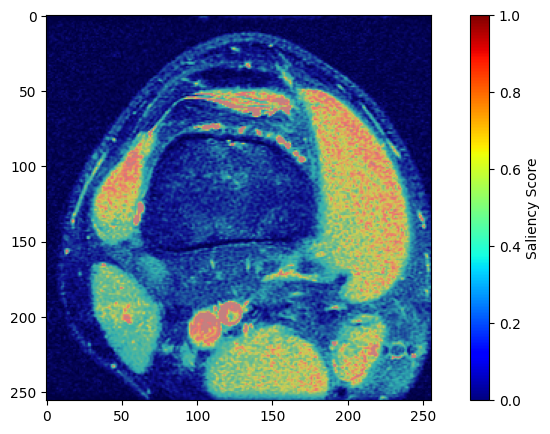

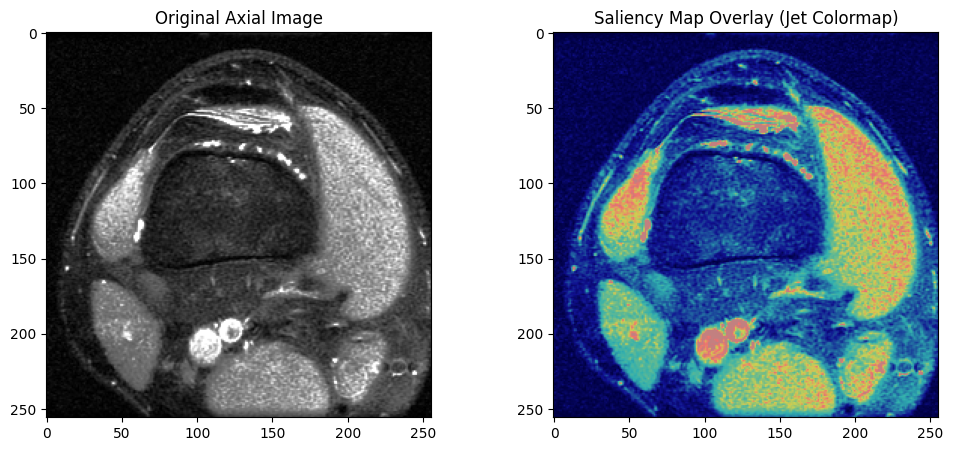

In [11]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def generate_saliency_map(model, image):
    # Wrap the model to compute gradients
    grad_model = tf.keras.Model(
        inputs=model.inputs, outputs=model.output[..., 0]
    )

    # Define a loss function to maximize the model output
    def loss(inputs):
        return -tf.reduce_mean(grad_model(inputs))

    # Create a gradient ascent optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

    # Convert the image to a tensor with batch dimension
    image_tensor = np.expand_dims(image, axis=0)
    # Convert the image_tensor to a TensorFlow Tensor
    image_tensor = tf.convert_to_tensor(image_tensor, dtype=tf.float32)

    # Make image_tensor a trainable variable
    image_tensor = tf.Variable(image_tensor)

    # Iteratively update the image to maximize the model output
    for _ in range(50):
        with tf.GradientTape() as tape:
            tape.watch(image_tensor)
            predictions = grad_model(image_tensor)
        grads = tape.gradient(predictions, image_tensor)
        optimizer.apply_gradients([(grads, image_tensor)])

    # Normalize the saliency map and clip values between 0 and 1
    saliency_map = tf.squeeze(image_tensor).numpy()
    saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
    saliency_map = np.clip(saliency_map, 0, 1)

    return saliency_map

# Load the pre-trained EfficientNetB0 model without the top layer
efficientnet_model = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(256, 256, 3))

# Generate saliency map for the axial plane
mri_axial_3channel = np.stack([mri_axial[0, :, :]] * 3, axis=-1)  # Convert axial to 3 channels
saliency_map_axial = generate_saliency_map(efficientnet_model, mri_axial_3channel)


# Overlay saliency map on the original axial image
heatmap_axial = cv2.applyColorMap(np.uint8(255 * saliency_map_axial), cv2.COLORMAP_JET)
heatmap_axial = cv2.resize(heatmap_axial, (mri_axial.shape[2], mri_axial.shape[1]))  # Resize to match original image shape
heatmap_axial = cv2.cvtColor(heatmap_axial, cv2.COLOR_BGR2RGB)  # Convert to RGB (3 channels)
overlayed_axial = cv2.addWeighted(mri_axial_3channel, 0.5, heatmap_axial, 0.5, 0)  # Now they have the same channels


# Create a colorbar
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(overlayed_axial)
fig.colorbar(cm.ScalarMappable(cmap=cm.jet), ax=ax, label='Saliency Score')


# Plot the original image and the overlayed image
plt.figure(figsize=(12, 5))
plt.subplot(121), plt.imshow(mri_axial[0, :, :], 'gray'), plt.title('Original Axial Image')
plt.subplot(122), plt.imshow(overlayed_axial), plt.title('Saliency Map Overlay (Jet Colormap)')
plt.show()

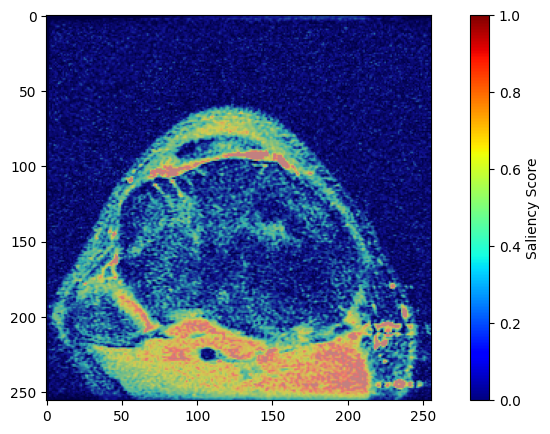

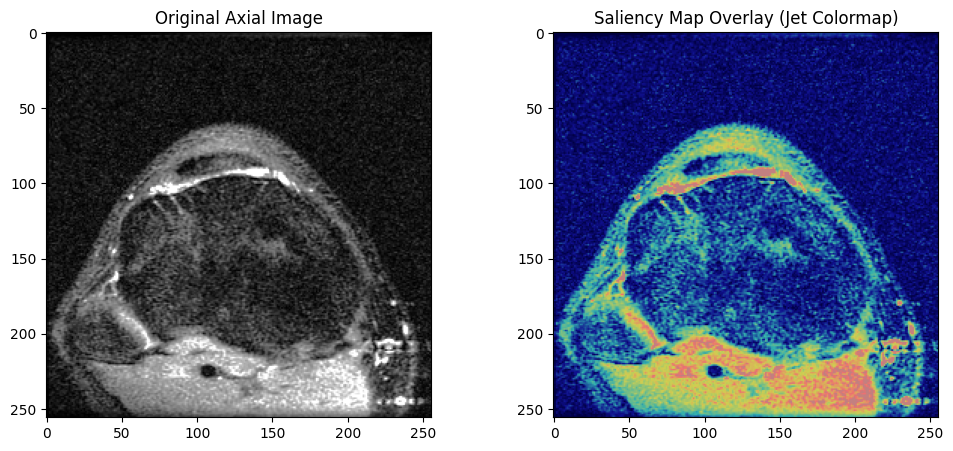

In [12]:

# Generate saliency map for the axial plane
mri_axial_3channel = np.stack([mri_axial[20, :, :]] * 3, axis=-1)  # Convert axial to 3 channels
saliency_map_axial = generate_saliency_map(efficientnet_model, mri_axial_3channel)

# Overlay saliency map on the original axial image
# Overlay saliency map on the original axial image
heatmap_axial = cv2.applyColorMap(np.uint8(255 * saliency_map_axial), cv2.COLORMAP_JET)
heatmap_axial = cv2.resize(heatmap_axial, (mri_axial.shape[2], mri_axial.shape[1]))  # Resize to match original image shape
heatmap_axial = cv2.cvtColor(heatmap_axial, cv2.COLOR_BGR2RGB)  # Convert to RGB (3 channels)
overlayed_axial = cv2.addWeighted(mri_axial_3channel, 0.5, heatmap_axial, 0.5, 0)  # Now they have the same channels


# Create a colorbar
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(overlayed_axial)
fig.colorbar(cm.ScalarMappable(cmap=cm.jet), ax=ax, label='Saliency Score')


# Plot the original image and the overlayed image
plt.figure(figsize=(12, 5))
plt.subplot(121), plt.imshow(mri_axial[20, :, :], 'gray'), plt.title('Original Axial Image')
plt.subplot(122), plt.imshow(overlayed_axial), plt.title('Saliency Map Overlay (Jet Colormap)')
plt.show()

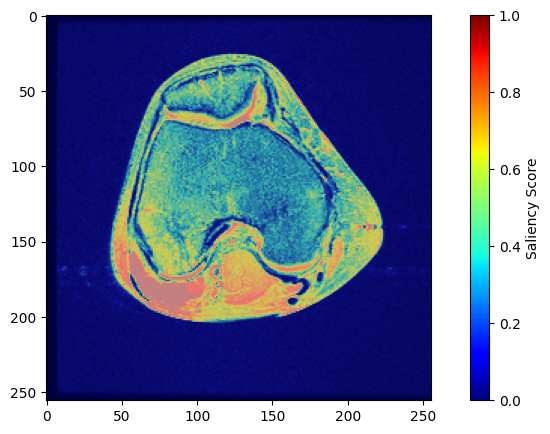

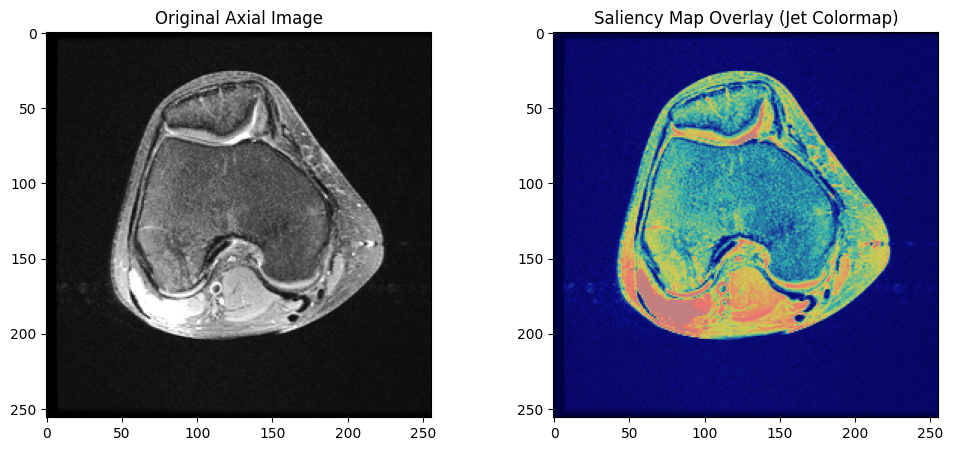

In [13]:
mri_axial = np.load('../content/drive/MyDrive/MRNet-v1.0/train/axial/0002.npy')
mri_axial_norm = mri_axial[15, :, :] / 255.0

# Generate saliency map for the axial plane
mri_axial_3channel = np.stack([mri_axial[15, :, :]] * 3, axis=-1)  # Convert axial to 3 channels
saliency_map_axial = generate_saliency_map(efficientnet_model, mri_axial_3channel)

# Overlay saliency map on the original axial image
# Overlay saliency map on the original axial image
heatmap_axial = cv2.applyColorMap(np.uint8(255 * saliency_map_axial), cv2.COLORMAP_JET)
heatmap_axial = cv2.resize(heatmap_axial, (mri_axial.shape[2], mri_axial.shape[1]))  # Resize to match original image shape
heatmap_axial = cv2.cvtColor(heatmap_axial, cv2.COLOR_BGR2RGB)  # Convert to RGB (3 channels)
overlayed_axial = cv2.addWeighted(mri_axial_3channel, 0.5, heatmap_axial, 0.5, 0)  # Now they have the same channels


# Create a colorbar
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(overlayed_axial)
fig.colorbar(cm.ScalarMappable(cmap=cm.jet), ax=ax, label='Saliency Score')


# Plot the original image and the overlayed image
plt.figure(figsize=(12, 5))
plt.subplot(121), plt.imshow(mri_axial[15, :, :], 'gray'), plt.title('Original Axial Image')
plt.subplot(122), plt.imshow(overlayed_axial), plt.title('Saliency Map Overlay (Jet Colormap)')
plt.show()

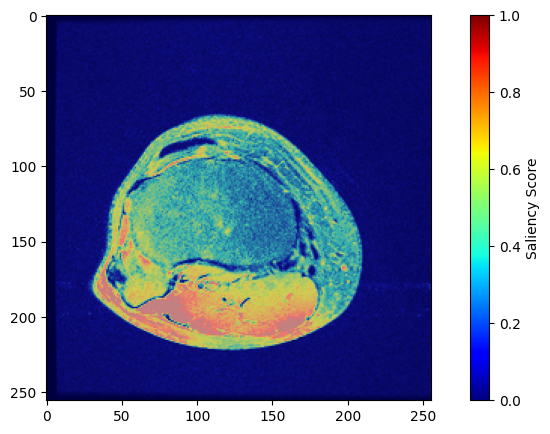

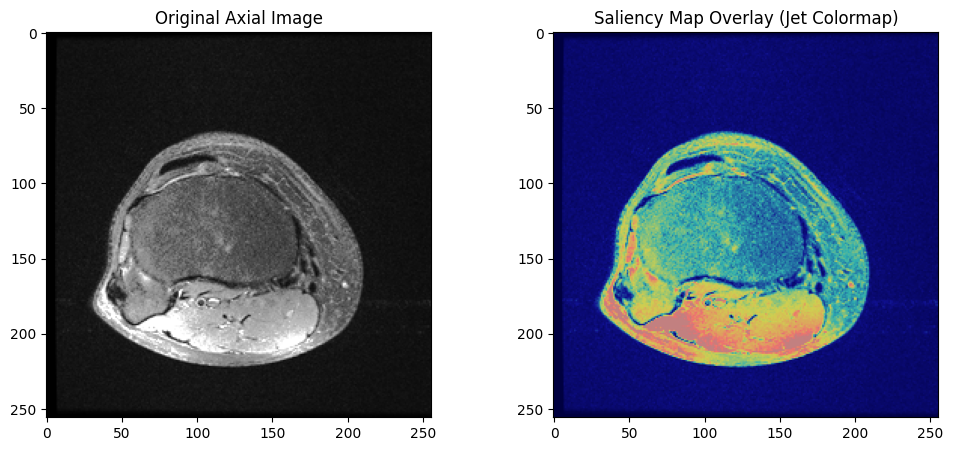

In [14]:
mri_axial = np.load('../content/drive/MyDrive/MRNet-v1.0/train/axial/0002.npy')
mri_axial_norm = mri_axial[30, :, :] / 255.0

# Generate saliency map for the axial plane
mri_axial_3channel = np.stack([mri_axial[30, :, :]] * 3, axis=-1)  # Convert axial to 3 channels
saliency_map_axial = generate_saliency_map(efficientnet_model, mri_axial_3channel)

# Overlay saliency map on the original axial image
heatmap_axial = cv2.applyColorMap(np.uint8(255 * saliency_map_axial), cv2.COLORMAP_JET)
heatmap_axial = cv2.resize(heatmap_axial, (mri_axial.shape[2], mri_axial.shape[1]))  # Resize to match original image shape
heatmap_axial = cv2.cvtColor(heatmap_axial, cv2.COLOR_BGR2RGB)  # Convert to RGB (3 channels)
overlayed_axial = cv2.addWeighted(mri_axial_3channel, 0.5, heatmap_axial, 0.5, 0)  # Now they have the same channels


# Create a colorbar
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(overlayed_axial)
fig.colorbar(cm.ScalarMappable(cmap=cm.jet), ax=ax, label='Saliency Score')


# Plot the original image and the overlayed image
plt.figure(figsize=(12, 5))
plt.subplot(121), plt.imshow(mri_axial[30, :, :], 'gray'), plt.title('Original Axial Image')
plt.subplot(122), plt.imshow(overlayed_axial), plt.title('Saliency Map Overlay (Jet Colormap)')
plt.show()